# Exploring Dandiset 000617: Allen Institute Openscope - Sequence Learning Project

> **Note**: This notebook was generated with the assistance of AI. Please be cautious when interpreting the code or results, and validate any findings with your own analysis.

## Overview of the Dandiset

This dandiset (DANDI:000617) contains two-photon calcium imaging data from the [Allen Institute Openscope - Sequence Learning Project](https://dandiarchive.org/dandiset/000617/0.250312.0130).

The experiment investigates how neural circuits in the mouse visual cortex learn to predict sequences of visual stimuli. In this experiment, head-fixed mice passively viewed sequences of three different natural movie clips (labeled 'A', 'B', 'C'), each having a duration of 2 seconds. The experiment begins with a baseline recording where the movie clips are presented in random order along with a 2-second grey screen (labeled 'X'). Subsequently, mice undergo training sessions where the movie clips are presented in a repeating temporal sequence (ABCABC...) to encourage sequence learning.

The experiment uses two-photon microscopy with simultaneous recordings from eight fields-of-view, including both layer 2/3 and layer 4 neurons from multiple visual cortical areas: V1 (VISp), LM (VISl), AM (VISam), and PM (VISpm). The mouse line used in the experiment is Cux2-CreERTS2:Camk2a-tTa; Ai93(TITL-GCaMP6f), which has GCaMP6f expression in excitatory neurons of both layer 4 and layer 2/3.

## What This Notebook Covers

In this notebook, we will:

1. Connect to the DANDI Archive and retrieve metadata about the dataset
2. Explore the structure of the NWB files in the dataset
3. Load and examine the calcium imaging data from one recording session
4. Visualize neural responses to the different movie stimuli
5. Analyze eye tracking and running behavior data
6. Explore the relationship between neural activity and behavioral measurements

By the end of this notebook, you should have a good understanding of the data structure and how to access and analyze the various types of data in this dataset.

## Required Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import remfile
import pynwb
from dandi.dandiapi import DandiAPIClient

# Use a cleaner plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['font.size'] = 12

## Exploring the Dandiset Metadata

In [2]:
# Connect to the DANDI Archive and retrieve metadata
client = DandiAPIClient()
dandiset = client.get_dandiset("000617", "0.250312.0130")
metadata = dandiset.get_raw_metadata()

print(f"Dandiset name: {metadata['name']}")
print(f"Dandiset URL: {metadata['url']}")
print(f"Dandiset DOI: {metadata['doi']}")
print(f"Version: {metadata['version']}")

Dandiset name: Allen Institute Openscope - Sequence Learning Project
Dandiset URL: https://dandiarchive.org/dandiset/000617/0.250312.0130
Dandiset DOI: 10.48324/dandi.000617/0.250312.0130
Version: 0.250312.0130


Let's extract some additional information from the metadata:

In [3]:
print("Description:")
print("------------")
# Format the description for better readability
description_lines = metadata['description'].split("\n")
for line in description_lines:
    print(line.strip())
    
print("\nKeywords:")
print("---------")
print(", ".join(metadata['keywords']))

Description:
------------
Adaptive and coordinated behavior requires that an animal be able to make predictions about the near and even far future. This intuition that some neural computations should be ‘predictive’ in their character has a long history, starting with ideas about how the receptive field structure of retinal ganglion cells relate to the statistics of natural visual scenes. Ideas about predictive computation have been most influential in thinking about the function of the neocortex. Here, the relatively stereotyped local circuitry of the neocortex has long led to speculation that each local circuit might be carrying out a somewhat similar, fundamental computation on its specific inputs. In addition, the organization of sensory-motor pathways into hierarchies (e.g., V1, V2, V4, IT in the ventral visual stream) with stereotyped feedforward and feedback connections has motivated ideas about hierarchical predictive codes, where higher levels of the hierarchy send predictions

## Exploring Files in the Dandiset

In [4]:
# Get a list of assets in the dandiset
assets = list(dandiset.get_assets())

# Print the total number of files
print(f"Total number of files: {len(assets)}")

# Get file paths for a specific subject
subject_files = [asset.path for asset in assets if "sub-684475" in asset.path]
print(f"\nNumber of files for subject 684475: {len(subject_files)}")

# Print a few example files
print("\nExample files:")
for file in subject_files[:10]:
    print(f"  {file}")

Total number of files: 1197

Number of files for subject 684475: 96

Example files:
  sub-684475/sub-684475_ses-1294084428-acq-1294179945-raw-movies_ophys.nwb
  sub-684475/sub-684475_ses-1294084428-acq-1294179943-raw-movies_ophys.nwb
  sub-684475/sub-684475_ses-1293785946-acq-1293914859-raw-movies_ophys.nwb
  sub-684475/sub-684475_ses-1294084428-acq-1294179942-raw-movies_ophys.nwb
  sub-684475/sub-684475_ses-1294259213-acq-1294370666-raw-movies_ophys.nwb
  sub-684475/sub-684475_ses-1294259213-acq-1294370664-raw-movies_ophys.nwb
  sub-684475/sub-684475_ses-1293785946-acq-1293914856-raw-movies_ophys.nwb
  sub-684475/sub-684475_ses-1294259213-acq-1294370663-raw-movies_ophys.nwb
  sub-684475/sub-684475_ses-1293785946-acq-1293914853-raw-movies_ophys.nwb
  sub-684475/sub-684475_ses-1293785946-acq-1293914860-raw-movies_ophys.nwb


Let's examine the file structure more closely to understand the organization of the dataset:

In [5]:
# Extract session IDs from the filenames
sessions = set()
for file in subject_files:
    if "ses-" in file:
        session_id = file.split("ses-")[1].split("-")[0]
        sessions.add(session_id)

print(f"Subject 684475 has {len(sessions)} recording sessions:")
for session in sorted(sessions):
    print(f"  Session {session}")

# Count files by acquisition
acquisition_counts = {}
for file in subject_files:
    if "acq-" in file:
        acq_id = file.split("acq-")[1].split("-")[0]
        acquisition_counts[acq_id] = acquisition_counts.get(acq_id, 0) + 1

print("\nFiles by acquisition ID:")
for acq_id, count in acquisition_counts.items():
    print(f"  Acquisition {acq_id}: {count} files")

Subject 684475 has 6 recording sessions:
  Session 1292488745
  Session 1292683599
  Session 1293292416
  Session 1293785946
  Session 1294084428
  Session 1294259213

Files by acquisition ID:
  Acquisition 1294179945: 1 files
  Acquisition 1294179943: 1 files
  Acquisition 1293914859: 1 files
  Acquisition 1294179942: 1 files
  Acquisition 1294370666: 1 files
  Acquisition 1294370664: 1 files
  Acquisition 1293914856: 1 files
  Acquisition 1294370663: 1 files
  Acquisition 1293914853: 1 files
  Acquisition 1293914860: 1 files
  Acquisition 1293914855: 1 files
  Acquisition 1294179939: 1 files
  Acquisition 1294179937: 1 files
  Acquisition 1293369050: 1 files
  Acquisition 1294179940: 1 files
  Acquisition 1293369052: 1 files
  Acquisition 1294179934: 1 files
  Acquisition 1294370657: 1 files
  Acquisition 1294370654: 1 files
  Acquisition 1294179936: 1 files
  Acquisition 1293369055: 1 files
  Acquisition 1293914863: 1 files
  Acquisition 1293369053: 1 files
  Acquisition 1292590333:

## Loading and Exploring an NWB File

Let's load an NWB file from the dataset and explore its structure:

In [6]:
# Let's use one of the files we saw earlier
file_path = "sub-684475/sub-684475_ses-1294084428-acq-1294179945-raw-movies_ophys.nwb"

# Get the download URL for the asset
asset = next(dandiset.get_assets_by_glob(file_path))
url = asset.download_url

# Use remfile to access the remote file without downloading it
remote_file = remfile.File(url)
h5_file = h5py.File(remote_file)
io = pynwb.NWBHDF5IO(file=h5_file)
nwb = io.read()

# Print basic information about the NWB file
print(f"Session ID: {nwb.identifier}")
print(f"Session description: {nwb.session_description}")
print(f"Session start time: {nwb.session_start_time}")
print(f"Experiment description: {nwb.experiment_description}")
print(f"Institution: {nwb.institution}")

/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.3.0 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Session ID: 1294179945
Session description: Ophys Session
Session start time: 2023-08-31 20:49:56.751000+00:00
Experiment description: ophys session
Institution: Allen Institute for Brain Science


Let's examine the subject information:

In [7]:
# Print subject information
subject = nwb.subject
print(f"Subject ID: {subject.subject_id}")
print(f"Age: {subject.age}")
print(f"Sex: {subject.sex}")
print(f"Species: {subject.species}")
print(f"Genotype: {subject.genotype}")
print(f"Description: {subject.description}")

Subject ID: 684475
Age: P108.0D
Sex: M
Species: Mus musculus
Genotype: Cux2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6f)/wt
Description: external: 684475 donor_id: (1281520997,) specimen_id: ['684475']


## Exploring Neural Activity Data

Let's examine the calcium imaging data available in the file:

In [8]:
# Check what processing modules are available
print("Available processing modules:")
for module_name in nwb.processing:
    print(f"  {module_name}")

Available processing modules:
  ophys
  running
  stimulus
  stimulus_ophys


Let's look at the ophys module, which contains the calcium imaging data:

In [9]:
# Get the ophys module
ophys = nwb.processing["ophys"]
print("Data interfaces in the ophys module:")
for name in ophys.data_interfaces:
    print(f"  {name}")

Data interfaces in the ophys module:
  corrected_fluorescence
  dff
  event_detection
  image_segmentation
  images
  neuropil_trace
  ophys_motion_correction_x
  ophys_motion_correction_y


### Examining the segmented ROIs (cells)

In [10]:
# Get information about the segmented ROIs (cells)
image_segmentation = ophys.data_interfaces["image_segmentation"]
plane_segmentation = image_segmentation.plane_segmentations["cell_specimen_table"]

# Convert to DataFrame for easier viewing
roi_df = plane_segmentation.to_dataframe()
print(f"Number of segmented ROIs: {len(roi_df)}")
print("\nROI properties:")
print(roi_df.head())

Number of segmented ROIs: 18

ROI properties:


            cell_specimen_id  height  mask_image_plane  max_correction_down  \
id                                                                            
1294200207                -1      18                 0                  6.0   
1294200209                -1      22                 0                  6.0   
1294200210                -1      17                 0                  6.0   
1294200212                -1      15                 0                  6.0   
1294200216                -1      17                 0                  6.0   

            max_correction_left  max_correction_right  max_correction_up  \
id                                                                         
1294200207                 12.0                   9.0               13.0   
1294200209                 12.0                   9.0               13.0   
1294200210                 12.0                   9.0               13.0   
1294200212                 12.0                   9.0             

Let's visualize the locations of the ROIs:

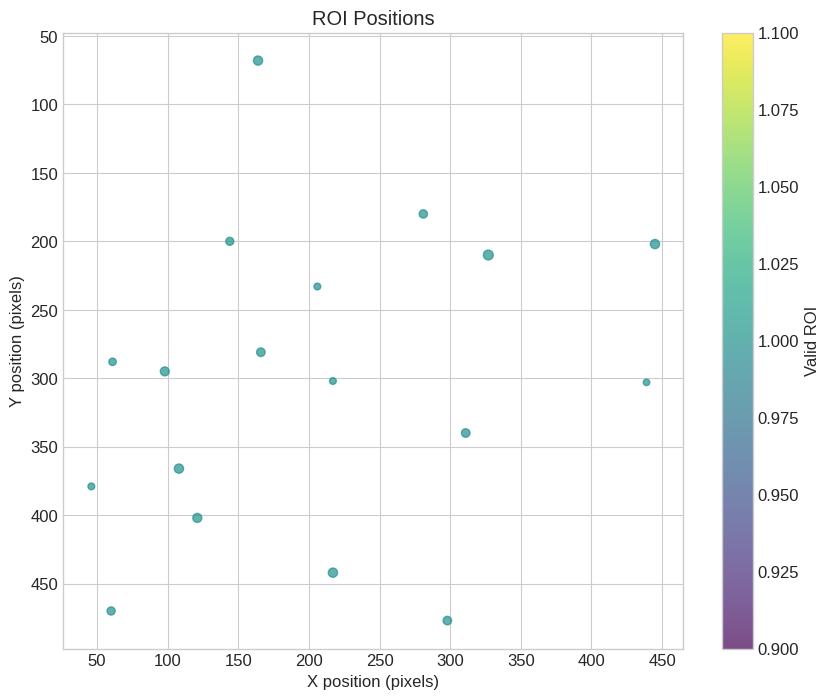

In [11]:
# Visualize the ROI positions
plt.figure(figsize=(10, 8))
plt.scatter(roi_df['x'], roi_df['y'], s=roi_df['width']*roi_df['height']/10, 
            alpha=0.7, c=roi_df['valid_roi'], cmap='viridis')
plt.colorbar(label='Valid ROI')
plt.title('ROI Positions')
plt.xlabel('X position (pixels)')
plt.ylabel('Y position (pixels)')
plt.gca().invert_yaxis()  # Invert y-axis to match imaging convention
plt.grid(True)
plt.show()

Let's look at the imaging data itself to understand the field of view:

Available images: ['average_image', 'max_projection', 'segmentation_mask_image']


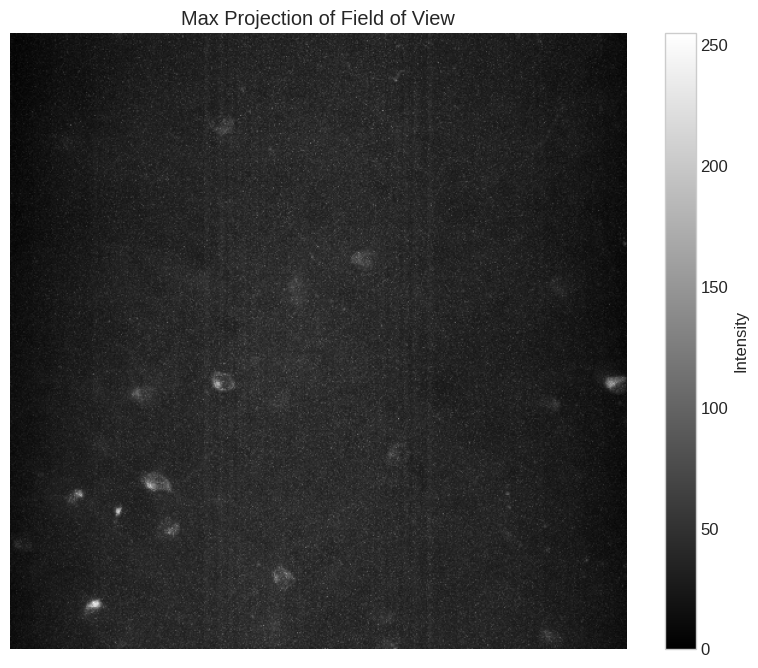

In [12]:
# Get the images from the ophys module
images = ophys.data_interfaces["images"]
available_images = list(images.images.keys())
print(f"Available images: {available_images}")

# Display the max projection image
max_proj = images.images["max_projection"]
plt.figure(figsize=(10, 8))
plt.imshow(max_proj.data[:], cmap='gray')
plt.title('Max Projection of Field of View')
plt.colorbar(label='Intensity')
plt.axis('off')
plt.show()

### Examining ΔF/F (dF/F) traces

In [13]:
# Get the dF/F data
dff = ophys.data_interfaces["dff"]
roi_response_series = dff.roi_response_series["traces"]

# Get the timestamps and data
timestamps = roi_response_series.timestamps[:]
dff_data = roi_response_series.data[:,:]

print(f"dF/F data shape: {dff_data.shape}")  # (time points, ROIs)
print(f"Timestamps length: {len(timestamps)}")
print(f"Recording duration: {timestamps[-1] - timestamps[0]:.2f} seconds")

dF/F data shape: (40018, 18)
Timestamps length: 40018
Recording duration: 4204.38 seconds


Let's plot the dF/F traces for a few example ROIs:

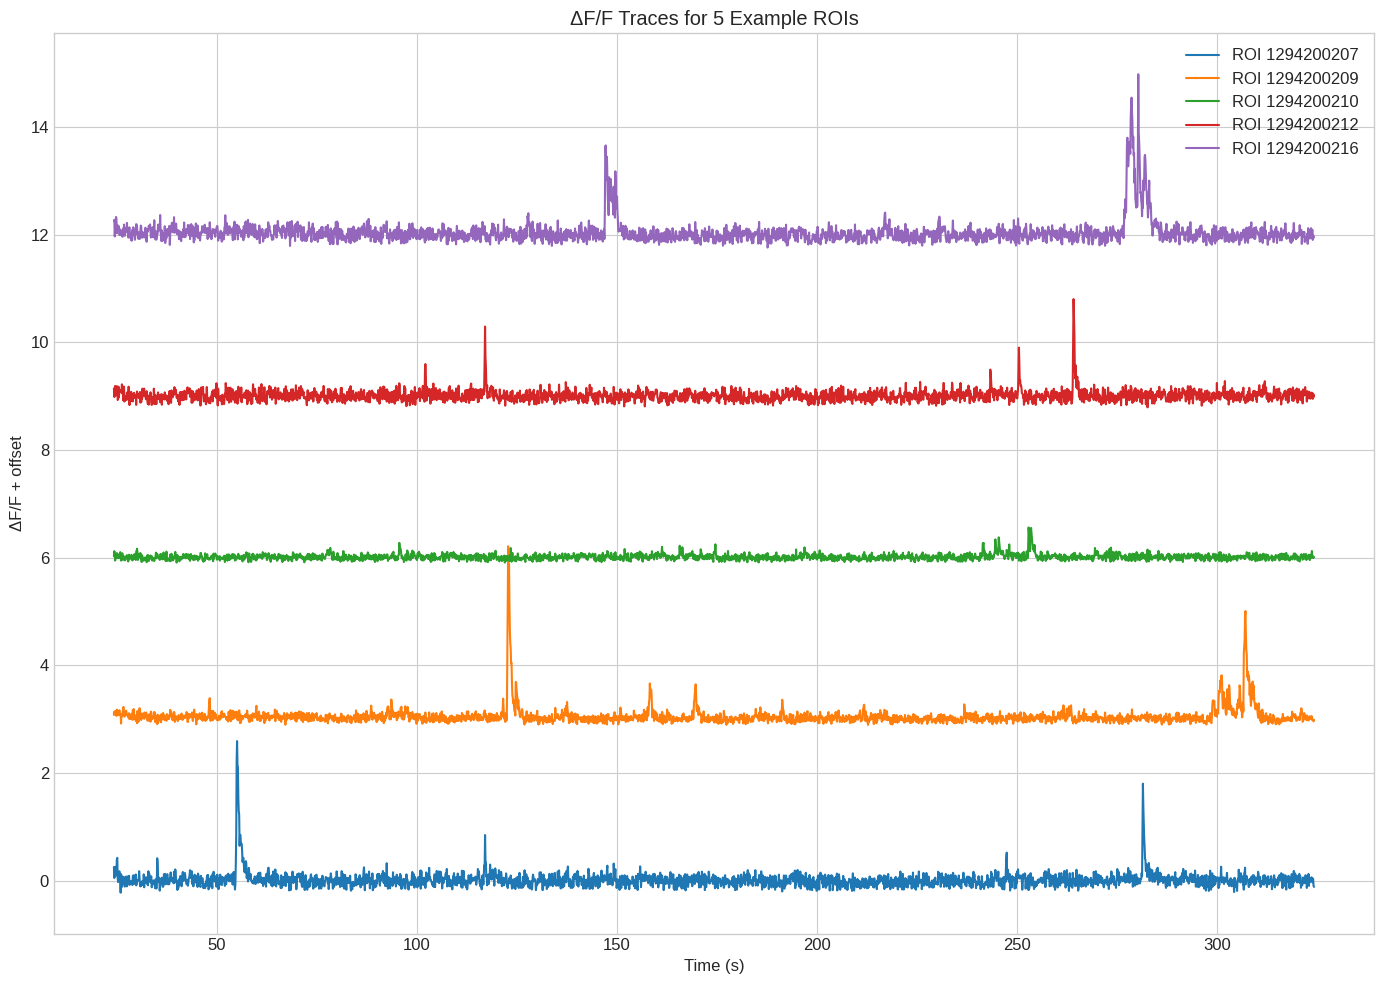

In [14]:
# Plot dF/F traces for a few ROIs
n_roi_to_plot = 5
time_window = 300  # seconds to plot

# Find the index corresponding to the time window
end_idx = np.searchsorted(timestamps, timestamps[0] + time_window)

plt.figure(figsize=(14, 10))
for i in range(n_roi_to_plot):
    plt.plot(timestamps[:end_idx], dff_data[:end_idx, i] + i*3, 
             label=f'ROI {roi_df.index[i]}')

plt.xlabel('Time (s)')
plt.ylabel('ΔF/F + offset')
plt.title(f'ΔF/F Traces for {n_roi_to_plot} Example ROIs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Examining Stimulus Presentations

In [15]:
# Check the available intervals in the NWB file
print("Available intervals:")
for interval_name in nwb.intervals:
    print(f"  {interval_name}")

Available intervals:
  gray_presentations
  movie_clip_A_presentations
  movie_clip_B_presentations
  movie_clip_C_presentations


Let's look at the movie clip presentations and their timing:

In [16]:
# Get dataframes for each stimulus type
gray_df = nwb.intervals['gray_presentations'].to_dataframe()
movie_a_df = nwb.intervals['movie_clip_A_presentations'].to_dataframe()
movie_b_df = nwb.intervals['movie_clip_B_presentations'].to_dataframe()
movie_c_df = nwb.intervals['movie_clip_C_presentations'].to_dataframe()

print(f"Number of gray presentations: {len(gray_df)}")
print(f"Number of movie clip A presentations: {len(movie_a_df)}")
print(f"Number of movie clip B presentations: {len(movie_b_df)}")
print(f"Number of movie clip C presentations: {len(movie_c_df)}")

# Print some examples
print("\nExample movie clip A presentations:")
print(movie_a_df.head())

Number of gray presentations: 63000
Number of movie clip A presentations: 63000
Number of movie clip B presentations: 63000
Number of movie clip C presentations: 63000

Example movie clip A presentations:
    start_time  stop_time stimulus_name  stimulus_block  frame  \
id                                                               
0     24.74554   24.76218  movie_clip_A             0.0    0.0   
1     24.76218   24.77886  movie_clip_A             0.0    1.0   
2     24.77886   24.79557  movie_clip_A             0.0    2.0   
3     24.79557   24.81217  movie_clip_A             0.0    3.0   
4     24.81217   24.82890  movie_clip_A             0.0    4.0   

              color  contrast  opacity  orientation              size units  \
id                                                                            
0   [1.0, 1.0, 1.0]       1.0      1.0          0.0  [1920.0, 1080.0]   pix   
1   [1.0, 1.0, 1.0]       1.0      1.0          0.0  [1920.0, 1080.0]   pix   
2   [1.0, 1.0, 1

Let's visualize when the different stimuli were presented:

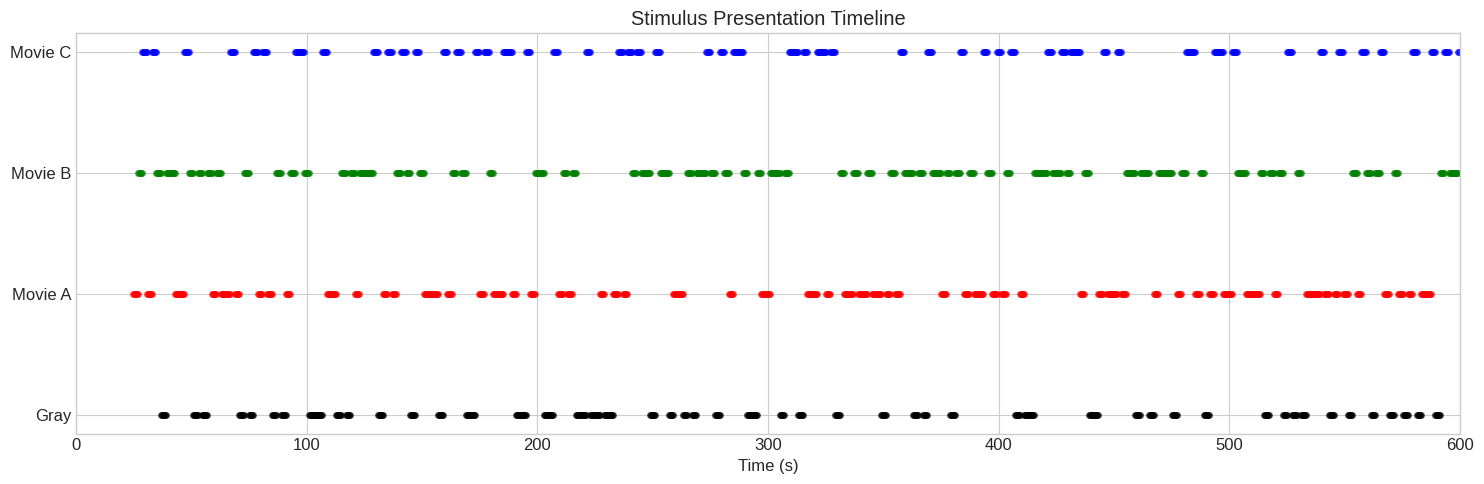

In [17]:
# Create a timeline of stimulus presentations
# We'll color-code each stimulus type
max_time = 600  # Plot first 10 minutes for clarity

# Filter dataframes to the time window we want to plot
gray_df_subset = gray_df[gray_df['start_time'] < max_time]
movie_a_df_subset = movie_a_df[movie_a_df['start_time'] < max_time]
movie_b_df_subset = movie_b_df[movie_b_df['start_time'] < max_time]
movie_c_df_subset = movie_c_df[movie_c_df['start_time'] < max_time]

plt.figure(figsize=(15, 5))

# Plot each stimulus type as horizontal bars
for i, (start, stop) in enumerate(zip(gray_df_subset['start_time'], gray_df_subset['stop_time'])):
    plt.plot([start, stop], [0, 0], 'k-', linewidth=5, alpha=0.7)
    
for i, (start, stop) in enumerate(zip(movie_a_df_subset['start_time'], movie_a_df_subset['stop_time'])):
    plt.plot([start, stop], [1, 1], 'r-', linewidth=5, alpha=0.7)
    
for i, (start, stop) in enumerate(zip(movie_b_df_subset['start_time'], movie_b_df_subset['stop_time'])):
    plt.plot([start, stop], [2, 2], 'g-', linewidth=5, alpha=0.7)
    
for i, (start, stop) in enumerate(zip(movie_c_df_subset['start_time'], movie_c_df_subset['stop_time'])):
    plt.plot([start, stop], [3, 3], 'b-', linewidth=5, alpha=0.7)

plt.yticks([0, 1, 2, 3], ['Gray', 'Movie A', 'Movie B', 'Movie C'])
plt.xlabel('Time (s)')
plt.title('Stimulus Presentation Timeline')
plt.xlim(0, max_time)
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

## Analyzing Neural Responses to Movie Stimuli

Now, let's analyze how neurons respond to the different movie clips:

In [18]:
# Define a function to extract trial-averaged responses for each stimulus type
def extract_trial_responses(dff_data, timestamps, stim_df, pre_time=0.5, post_time=2.5):
    """
    Extract trial-averaged responses for each stimulus.
    
    Parameters:
    -----------
    dff_data: array
        The dF/F data (time x ROIs)
    timestamps: array
        Timestamps for each dF/F data point
    stim_df: DataFrame
        Stimulus presentation dataframe
    pre_time: float
        Time before stimulus onset to include (seconds)
    post_time: float
        Time after stimulus onset to include (seconds)
    
    Returns:
    --------
    trial_responses: dict
        Dictionary with trial-averaged responses
    """
    # Initialize dictionary to store responses
    trial_responses = {
        'time': np.arange(-pre_time, post_time, 0.1),  # Assuming 10Hz sampling
        'mean_response': [],
        'sem_response': [],
    }
    
    n_rois = dff_data.shape[1]
    n_timepoints = len(trial_responses['time'])
    all_trials = np.zeros((len(stim_df), n_timepoints, n_rois))
    
    # Loop through all presentations
    for i, (start_time, _) in enumerate(zip(stim_df['start_time'], stim_df['stop_time'])):
        # Find indices in dff_data that correspond to this time window
        start_idx = np.max([0, np.searchsorted(timestamps, start_time - pre_time)])
        end_idx = np.min([len(timestamps), np.searchsorted(timestamps, start_time + post_time)])
        
        # Skip if the window is too short
        if end_idx - start_idx < n_timepoints:
            continue
        
        # Extract the dF/F data for this trial
        trial_data = dff_data[start_idx:start_idx+n_timepoints, :]
        all_trials[i, :, :] = trial_data
    
    # Calculate mean and SEM across trials
    trial_responses['mean_response'] = np.nanmean(all_trials, axis=0)  # time x ROIs
    trial_responses['sem_response'] = np.nanstd(all_trials, axis=0) / np.sqrt(len(stim_df))
    
    return trial_responses

Extract trial-averaged responses for each stimulus type:

In [19]:
# Extract trial-averaged responses
gray_responses = extract_trial_responses(dff_data, timestamps, gray_df)
movie_a_responses = extract_trial_responses(dff_data, timestamps, movie_a_df)
movie_b_responses = extract_trial_responses(dff_data, timestamps, movie_b_df)
movie_c_responses = extract_trial_responses(dff_data, timestamps, movie_c_df)

print(f"Extracted responses for {dff_data.shape[1]} ROIs")
print(f"Time points per trial: {len(gray_responses['time'])}")

Extracted responses for 18 ROIs
Time points per trial: 30


Let's visualize the average responses of a few example neurons to the different stimuli:

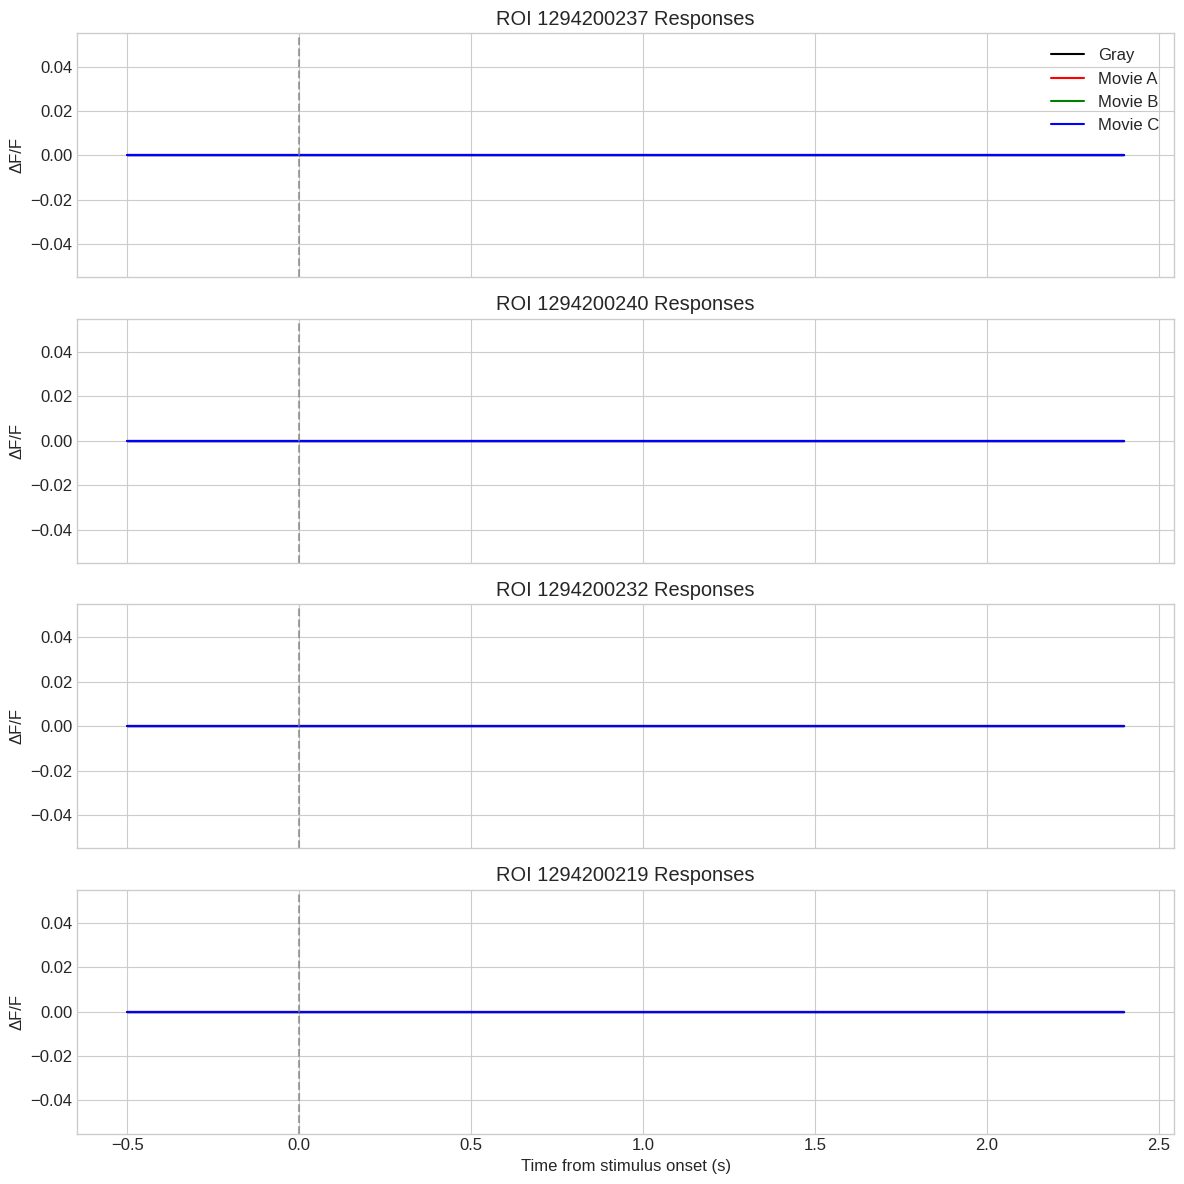

In [20]:
# Plot the average responses for a few example ROIs
n_roi_to_plot = 4
roi_indices = np.random.choice(dff_data.shape[1], n_roi_to_plot, replace=False)

fig, axes = plt.subplots(n_roi_to_plot, 1, figsize=(12, 3*n_roi_to_plot), sharex=True)

for i, roi_idx in enumerate(roi_indices):
    ax = axes[i]
    
    # Plot responses to each stimulus
    ax.plot(gray_responses['time'], gray_responses['mean_response'][:, roi_idx], 'k-', label='Gray')
    ax.fill_between(gray_responses['time'], 
                    gray_responses['mean_response'][:, roi_idx] - gray_responses['sem_response'][:, roi_idx], 
                    gray_responses['mean_response'][:, roi_idx] + gray_responses['sem_response'][:, roi_idx], 
                    color='k', alpha=0.2)
    
    ax.plot(movie_a_responses['time'], movie_a_responses['mean_response'][:, roi_idx], 'r-', label='Movie A')
    ax.fill_between(movie_a_responses['time'], 
                    movie_a_responses['mean_response'][:, roi_idx] - movie_a_responses['sem_response'][:, roi_idx], 
                    movie_a_responses['mean_response'][:, roi_idx] + movie_a_responses['sem_response'][:, roi_idx], 
                    color='r', alpha=0.2)
    
    ax.plot(movie_b_responses['time'], movie_b_responses['mean_response'][:, roi_idx], 'g-', label='Movie B')
    ax.fill_between(movie_b_responses['time'], 
                    movie_b_responses['mean_response'][:, roi_idx] - movie_b_responses['sem_response'][:, roi_idx], 
                    movie_b_responses['mean_response'][:, roi_idx] + movie_b_responses['sem_response'][:, roi_idx], 
                    color='g', alpha=0.2)
    
    ax.plot(movie_c_responses['time'], movie_c_responses['mean_response'][:, roi_idx], 'b-', label='Movie C')
    ax.fill_between(movie_c_responses['time'], 
                    movie_c_responses['mean_response'][:, roi_idx] - movie_c_responses['sem_response'][:, roi_idx], 
                    movie_c_responses['mean_response'][:, roi_idx] + movie_c_responses['sem_response'][:, roi_idx], 
                    color='b', alpha=0.2)
    
    ax.axvline(x=0, linestyle='--', color='gray', alpha=0.7)  # Mark stimulus onset
    ax.set_ylabel('ΔF/F')
    ax.set_title(f'ROI {roi_df.index[roi_idx]} Responses')
    
    if i == 0:
        ax.legend(loc='upper right')

axes[-1].set_xlabel('Time from stimulus onset (s)')
plt.tight_layout()
plt.show()

## Exploring Eye Tracking Data

In [21]:
# Access the eye tracking data
eye_tracking = nwb.acquisition["EyeTracking"]
eye_data = eye_tracking.eye_tracking.data[:]
eye_timestamps = eye_tracking.eye_tracking.timestamps[:]
pupil_area = eye_tracking.pupil_tracking.area[:]
blinks = eye_tracking.likely_blink.data[:]

print(f"Eye tracking data shape: {eye_data.shape}")
print(f"Number of data points: {len(eye_timestamps)}")
print(f"Recording duration: {eye_timestamps[-1] - eye_timestamps[0]:.2f} seconds")

Eye tracking data shape: (254226, 2)
Number of data points: 254226
Recording duration: nan seconds


Let's visualize the eye tracking data:

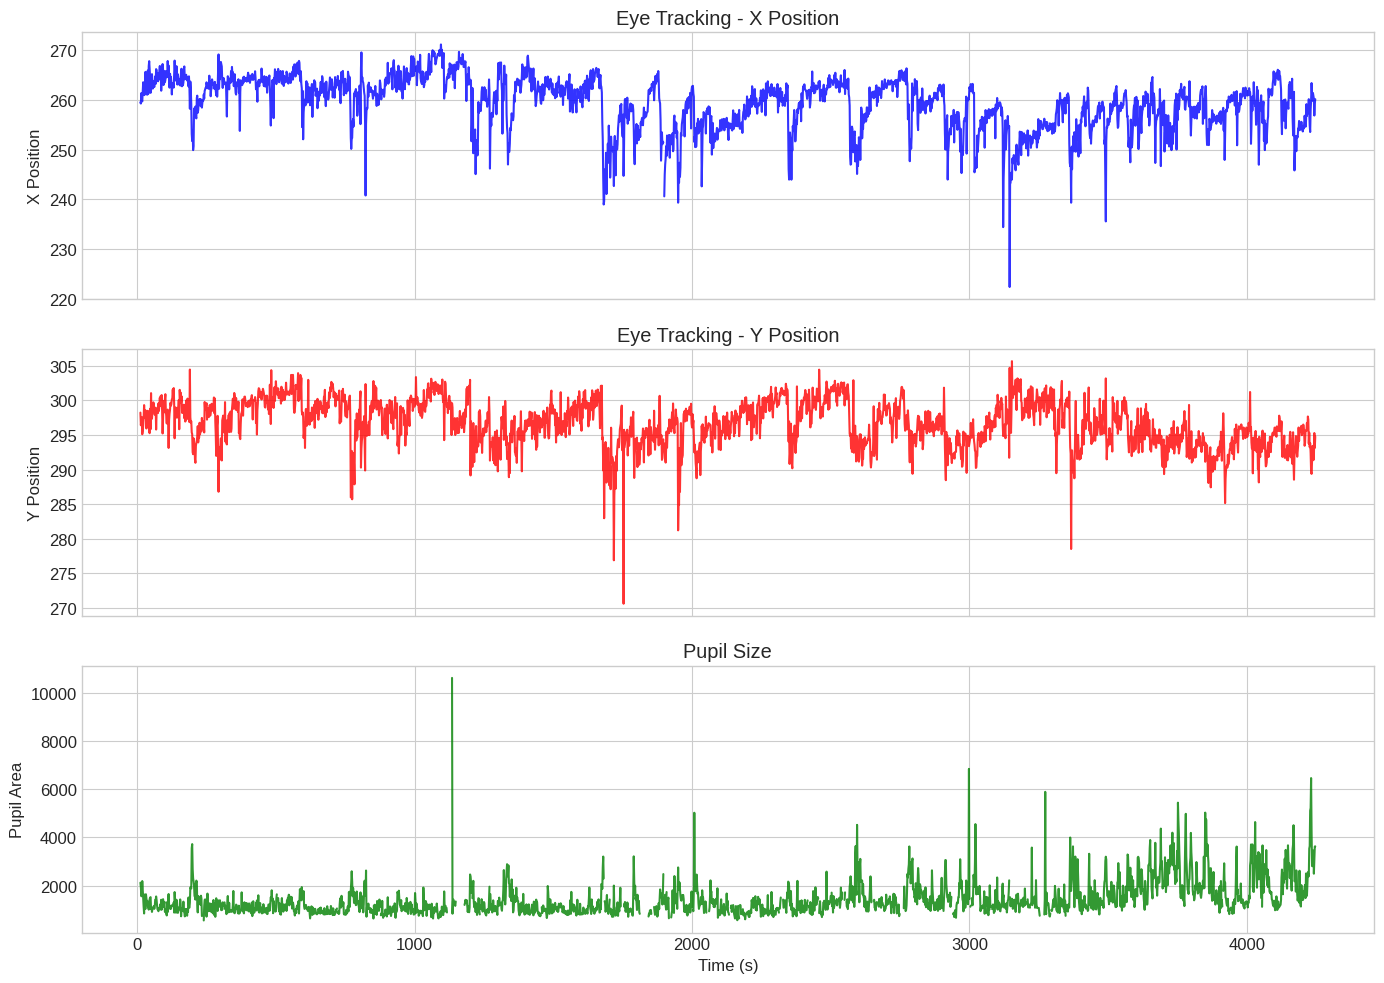

In [22]:
# Plot eye position over time
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# Plot x position
axes[0].plot(eye_timestamps[::100], eye_data[::100, 0], 'b-', alpha=0.8)
axes[0].set_ylabel('X Position')
axes[0].set_title('Eye Tracking - X Position')

# Plot y position
axes[1].plot(eye_timestamps[::100], eye_data[::100, 1], 'r-', alpha=0.8)
axes[1].set_ylabel('Y Position')
axes[1].set_title('Eye Tracking - Y Position')

# Plot pupil area
axes[2].plot(eye_timestamps[::100], pupil_area[::100], 'g-', alpha=0.8)
axes[2].set_ylabel('Pupil Area')
axes[2].set_xlabel('Time (s)')
axes[2].set_title('Pupil Size')

plt.tight_layout()
plt.show()

Let's visualize the eye position as a heatmap:

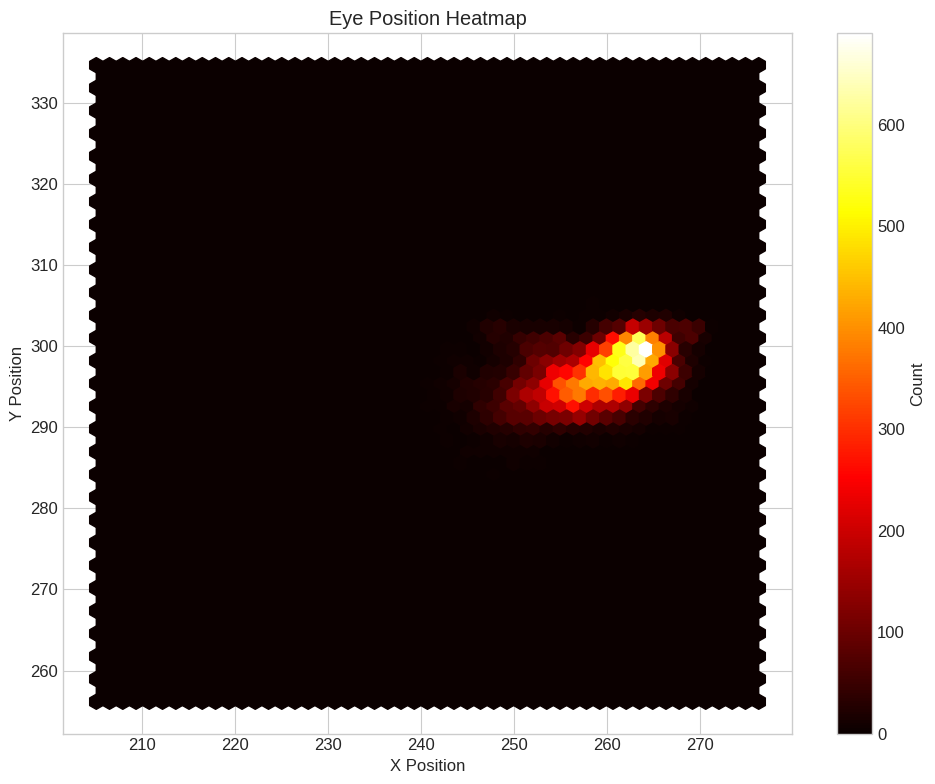

In [23]:
# Create a heatmap of eye positions
plt.figure(figsize=(10, 8))
plt.hexbin(eye_data[::10, 0], eye_data[::10, 1], gridsize=50, cmap='hot')
plt.colorbar(label='Count')
plt.title('Eye Position Heatmap')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.tight_layout()
plt.show()

## Examining Running Behavior

In [24]:
# Access running data
running = nwb.processing["running"]
speed = running.data_interfaces["speed"].data[:]
speed_timestamps = running.data_interfaces["speed"].timestamps[:]

print(f"Running data length: {len(speed)}")
print(f"Recording duration: {speed_timestamps[-1] - speed_timestamps[0]:.2f} seconds")
print(f"Mean running speed: {np.mean(speed):.2f} cm/s")
print(f"Max running speed: {np.max(speed):.2f} cm/s")

Running data length: 252000
Recording duration: 4203.47 seconds
Mean running speed: 0.01 cm/s
Max running speed: 6.42 cm/s


Let's visualize the running speed over time:

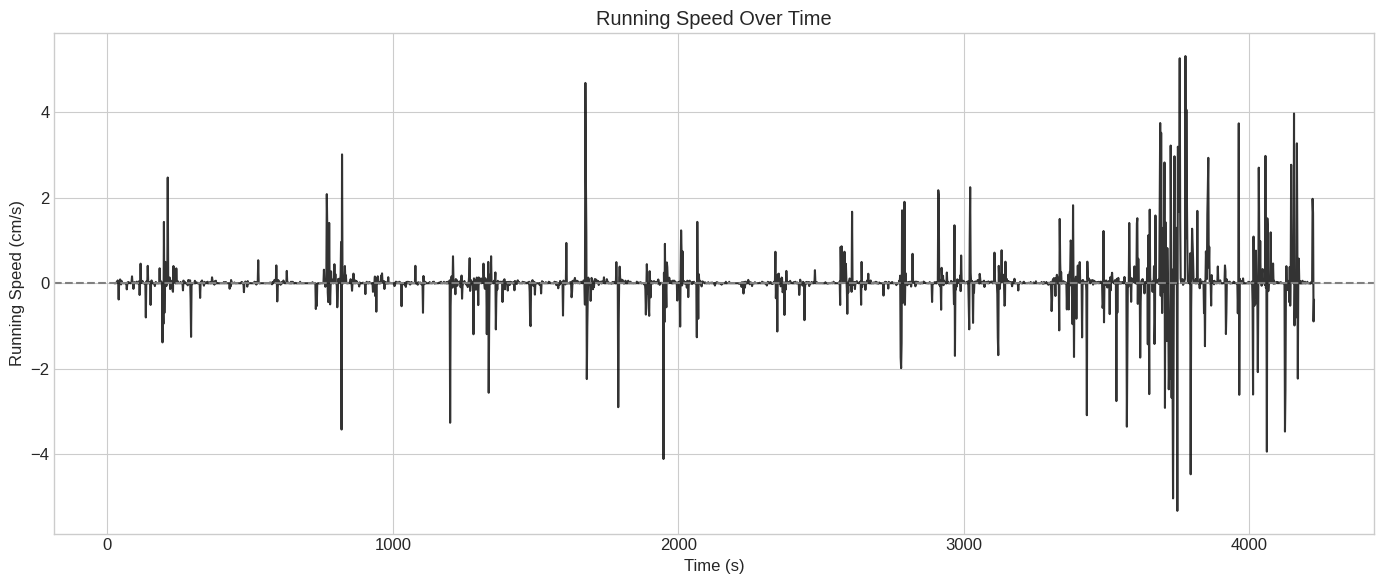

In [25]:
# Plot running speed
plt.figure(figsize=(14, 6))
plt.plot(speed_timestamps[::100], speed[::100], 'k-', alpha=0.8)
plt.axhline(y=0, color='gray', linestyle='--')
plt.ylabel('Running Speed (cm/s)')
plt.xlabel('Time (s)')
plt.title('Running Speed Over Time')
plt.grid(True)
plt.tight_layout()
plt.show()

## Relating Neural Activity to Behavior

Let's examine how neural activity relates to running speed by computing the correlation between each neuron's activity and the animal's running speed:

In [26]:
# Resample the running speed to match the dF/F timestamps
from scipy.interpolate import interp1d

# Create an interpolation function for running speed
speed_interp = interp1d(speed_timestamps, speed, bounds_error=False, fill_value=np.nan)

# Interpolate speed to match dF/F timestamps
interp_speed = speed_interp(timestamps)

# Calculate correlation between each neuron and running speed
correlations = []
p_values = []
from scipy.stats import pearsonr
for i in range(dff_data.shape[1]):
    # Remove NaNs for correlation calculation
    valid_idx = ~np.isnan(interp_speed)
    if np.sum(valid_idx) > 100:  # Only compute if we have enough data
        r, p = pearsonr(dff_data[valid_idx, i], interp_speed[valid_idx])
        correlations.append(r)
        p_values.append(p)
    else:
        correlations.append(np.nan)
        p_values.append(np.nan)

# Convert to numpy arrays
correlations = np.array(correlations)
p_values = np.array(p_values)

Let's visualize the distribution of correlations between neural activity and running speed:

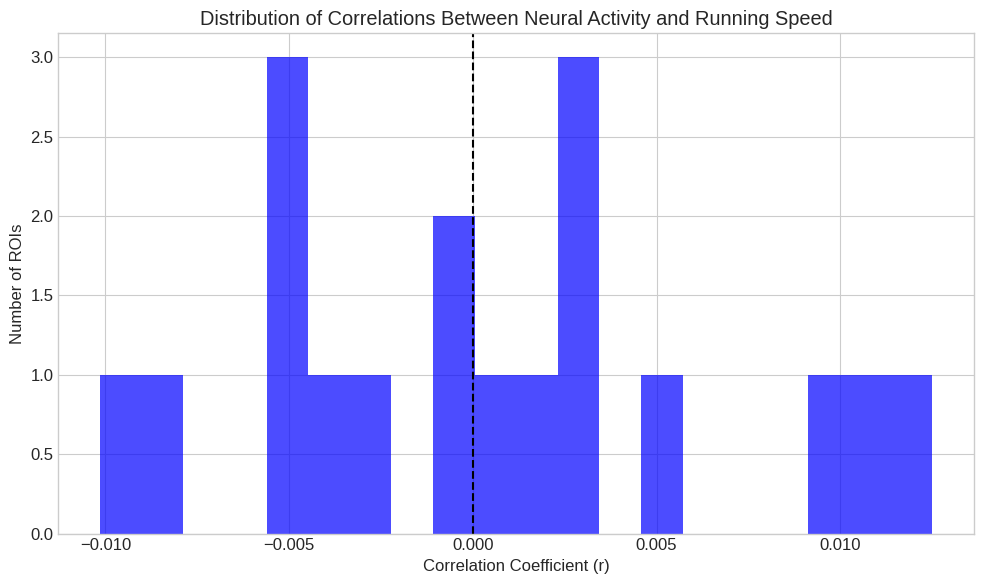

In [27]:
# Plot histogram of correlations
plt.figure(figsize=(10, 6))
plt.hist(correlations, bins=20, alpha=0.7, color='blue')
plt.axvline(x=0, color='k', linestyle='--')
plt.xlabel('Correlation Coefficient (r)')
plt.ylabel('Number of ROIs')
plt.title('Distribution of Correlations Between Neural Activity and Running Speed')
plt.grid(True)
plt.tight_layout()
plt.show()

Let's visualize the dF/F traces of the neurons with the highest positive and negative correlations with running speed:

Neuron with highest positive correlation: ROI 1294200243, r = 0.013
Neuron with highest negative correlation: ROI 1294200207, r = -0.010


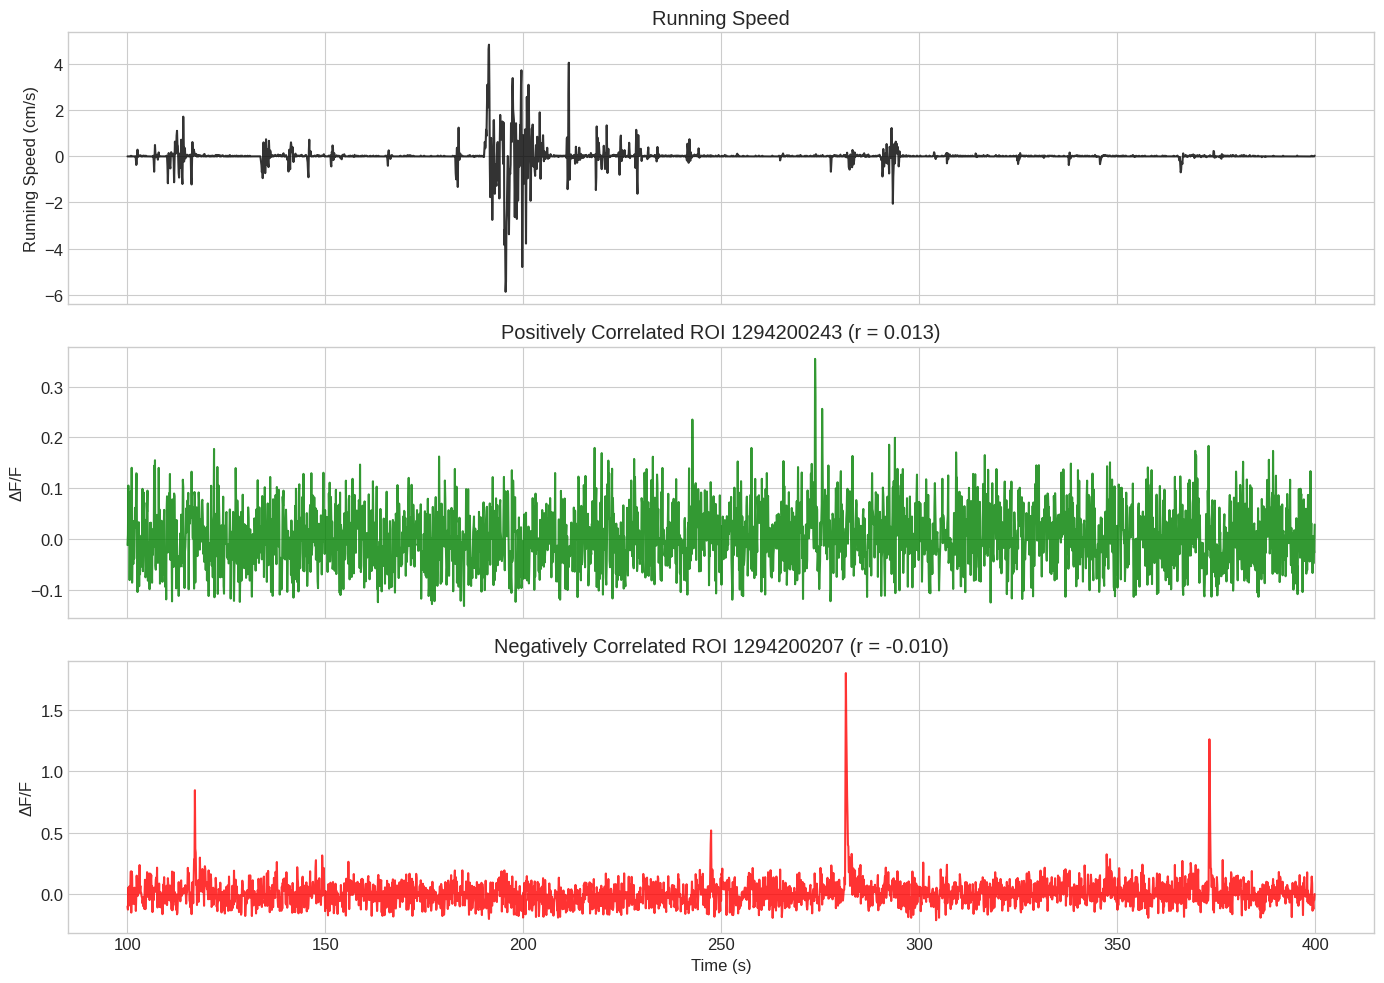

In [28]:
# Find the neurons with highest positive and negative correlations
top_pos_idx = np.nanargmax(correlations)
top_neg_idx = np.nanargmin(correlations)

print(f"Neuron with highest positive correlation: ROI {roi_df.index[top_pos_idx]}, r = {correlations[top_pos_idx]:.3f}")
print(f"Neuron with highest negative correlation: ROI {roi_df.index[top_neg_idx]}, r = {correlations[top_neg_idx]:.3f}")

# Plot a time window of data to see the relationship
time_window = 300  # seconds
start_time = 100  # start at 100s to skip initial transients
end_idx = np.searchsorted(timestamps, start_time + time_window)
start_idx = np.searchsorted(timestamps, start_time)

fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# Plot running speed
axes[0].plot(timestamps[start_idx:end_idx], interp_speed[start_idx:end_idx], 'k-', alpha=0.8)
axes[0].set_ylabel('Running Speed (cm/s)')
axes[0].set_title('Running Speed')

# Plot positively correlated neuron
axes[1].plot(timestamps[start_idx:end_idx], dff_data[start_idx:end_idx, top_pos_idx], 'g-', alpha=0.8)
axes[1].set_ylabel('ΔF/F')
axes[1].set_title(f'Positively Correlated ROI {roi_df.index[top_pos_idx]} (r = {correlations[top_pos_idx]:.3f})')

# Plot negatively correlated neuron
axes[2].plot(timestamps[start_idx:end_idx], dff_data[start_idx:end_idx, top_neg_idx], 'r-', alpha=0.8)
axes[2].set_ylabel('ΔF/F')
axes[2].set_xlabel('Time (s)')
axes[2].set_title(f'Negatively Correlated ROI {roi_df.index[top_neg_idx]} (r = {correlations[top_neg_idx]:.3f})')

plt.tight_layout()
plt.show()

## Summary

In this notebook, we've explored the Allen Institute Openscope - Sequence Learning Project dataset. We've learned how to:

1. Access metadata about the dandiset using the DANDI API
2. Load and explore NWB files containing two-photon calcium imaging data
3. Examine ROI (neuron) properties and visualize their locations
4. Analyze neural responses to different movie stimuli
5. Explore eye tracking and running behavior data
6. Correlate neural activity with behavioral measurements

For future exploration, you might consider:
- Analyzing data across multiple sessions to study sequence learning effects
- Comparing responses across different cortical areas
- Developing decoding models to predict stimulus identity from neural activity
- Implementing more advanced analyses of eye movements during stimulus presentations